# Building a RAG Agent with LangGraph, LLaMA3–70b/Claude-3, and Scaling with Amazon Bedrock

Explore how to build an intelligent using agent, langgraph and Claude-3/LLaMA-3 from Amazon Bedrock. This advanced RAG agent integrates several cutting-edge ideas from recent research to enhance its capabilities.

* Adaptive Routing (paper): Based on the Adaptive RAG paper, our agent intelligently routes questions to different retrieval approaches, leveraging the strengths of each method for optimal performance.
* Fallback to Web Search (paper): Inspired by the Corrective RAG paper, our agent falls back to web search if the retrieved documents are not relevant, ensuring comprehensive coverage.
* Self-Correction (paper): Incorporating concepts from the Self-RAG paper, our agent identifies and corrects hallucinations or incomplete answers.

We'll use LangGraph to build complex, multi-step workflows that involve language models and other components. By combining these research ideas, our agent will provide accurate and informative responses to challenging queries.
This blog post expands on the work presented in Langchain-ai's notebook, illustrating how you can scale with cloud processing power. We will port the original notebook to utilize Amazon Bedrock for LLM inference to scale our embedding and text generation capabilities. The choice of vector stores (local chromaDB) will remain unchanged, and we will discover how to scale this part in future blog posts.

In [1]:
#! pip install -U langchain_community tiktoken chromadb langchain langgraph tavily-python langchain-aws
!pip show langchain_community tiktoken chromadb langchain langgraph tavily-python langchain-aws chromadb

Name: langchain-community
Version: 0.0.34
Summary: Community contributed LangChain integrations.
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /home/alfred/anaconda3/envs/dui/lib/python3.11/site-packages
Requires: aiohttp, dataclasses-json, langchain-core, langsmith, numpy, PyYAML, requests, SQLAlchemy, tenacity
Required-by: langchain, ragas
---
Name: tiktoken
Version: 0.6.0
Summary: tiktoken is a fast BPE tokeniser for use with OpenAI's models
Home-page: 
Author: Shantanu Jain
Author-email: shantanu@openai.com
License: MIT License

Copyright (c) 2022 OpenAI, Shantanu Jain

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the S

## 0. Setting Up LangSmith Tracing
LangSmith is a powerful tracing tool that allows you to monitor and debug LangChain-based applications. Setting up a connection to LangSmith in this notebook will give us valuable insights into the inner workings of our RAG agent.

To enable tracing, set the LANGCHAIN_TRACING_V2 environment variable to "true". Then specify the LANGCHAIN_ENDPOINT and LANGCHAIN_API_KEY with the appropriate values for your LangSmith account. If you don't have an account, sign up at LangSmith Signup and obtain your API key.

If you are looking for a self-hosted alternative to LangSmith, check out Langfuse.

Furthermore, we will set our keys to connect to the AWS cloud.

If you work on an AWS resource, like Amazon SageMaker, your Execution Role already has the default connection set for you. To give you a broad place to play with the tech, find below a method for Google Colab as well as your local computer (with AWS CLI setup through the aws configure command).



In [1]:
import os
#from google.colab import userdata


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        #os.environ[var] = getpass.getpass(f"Please provide your {var}")
        os.environ[var] = os.getenv(var.replace("KEY", "token").lower())

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith.
# This will help you visualize and debug the control flow


# if you work on Google Colab use the following to retrieve your API keys
langchain_api_key = os.getenv('langchain_api_token')
tavily_ai_api_key = os.getenv('tavily_api_token')
#aws_access_key_id = userdata.get('aws_access_key_id')
#aws_secret_access_key = userdata.get('aws_secret_access_key')
aws_region = "us-west-2" # choose your region you operate in

# # otherwise initialize your credentials as need be by uncommenting below:
# langchain_api_key = <YOUR API KEY>
# aws_access_key_id = <YOUR SECRETS KEY ID>
# aws_secret_access_key =  <YOUR SECRETS KEY SECRET>
### Tracing (optional)

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key

## 0.1 Creating a Bedrock Runtime Client
We'll create a Bedrock runtime client to connect to the Amazon Bedrock service. Bedrock, a fully managed service by AWS, allows developers to build and deploy generative AI models like large language models (LLMs). This client will enable us to leverage pre-trained LLMs from Amazon, such as the powerful LLaMA3 model from Meta.

Connecting to Bedrock is crucial for building our scalable and secure RAG agent, as it provides the necessary language model for generation capabilities. With the Bedrock runtime client in place, we can integrate LLaMA3 into our workflow and use its advanced natural language processing capabilities to generate accurate responses.

In [2]:
import boto3
from langchain_aws import BedrockLLM, ChatBedrock
#from langchain_community.llms import Bedrock
from langchain_aws import BedrockLLM


bedrock_client = boto3.client("bedrock-runtime")
model_id_c3 = 'anthropic.claude-3-haiku-20240307-v1:0'
model_id_c3 = 'anthropic.claude-3-sonnet-20240229-v1:0'

model_id_l3= 'meta.llama3-70b-instruct-v1:0'
model_id_c2 = 'anthropic.claude-v2:1'
inference_modifier = {
    "max_tokens": 2048,
    "temperature": 0.01,
    "top_k": 50,
    "top_p": 0.95,
    "stop_sequences": ["\n\n\nHuman"],
}
    
llm_c3 = bedrock_claude3_chat = ChatBedrock(
    model_id=model_id_c3,
    client=bedrock_client,
    model_kwargs=inference_modifier,
    region_name=aws_region,
)  
llm = bedrock_llama3_llm = BedrockLLM(
    model_id=model_id_l3,
    client=bedrock_client,
    model_kwargs={"temperature": 0.1, "max_gen_len":1024},
)  

## 1. RAG Injection

In [3]:
from langchain_community.embeddings import BedrockEmbeddings

# Choose from a set of embedding models hosted on Amazon Bedrock
# Provider  | Model Name                        | Model ID
# -------------------------------------------------------------------------------
# Amazon    | Titan Embeddings G1 - Text 1.x   | amazon.titan-embed-text-v1
# Amazon    | Titan Embedding Text v2 1.x       | amazon.titan-embed-text-v2:0:8k
# Cohere    | Embed English 3.x                 | cohere.embed-english-v3
# Cohere   | Embed Multilingual 3.x           | cohere.embed-multilingual-v3
embedding_model_id = "amazon.titan-embed-text-v2:0"
embeddings = BedrockEmbeddings(client=bedrock_client, model_id=embedding_model_id)

In [56]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from langchain_community.embeddings.bedrock import BedrockEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

class MyEmbeddingFunction(EmbeddingFunction):
    def __init__(self, client, region_name: str, model_id: str):
        self.embedder = BedrockEmbeddings(
            client=client,
            region_name=region_name,
            model_id=model_id
        )
    def embed_query(self, query: str) -> Embeddings:
        return self.embedder.embed_query(query)
    def embed_documents(self, documents: list[str]) -> Embeddings:
        return self.embedder.embed_documents(documents)

urls = [
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127599/",
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127585/",
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127587/",
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127583",
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127584/",
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127593/",
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127580/",
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127581/"
]
docs = [WebBaseLoader(url).load() for url in urls]    
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=400
)
doc_splits = text_splitter.split_documents(docs_list)

embedding_function = MyEmbeddingFunction(client = bedrock_client,
                                         region_name=aws_region,
                                         model_id=embedding_model_id)
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=embedding_function,
    collection_name="rag-chroma-titan-embed-text-v2-0",
)
retriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={'k': 3, 'lambda_mult': 0.25})

### 1.1 RAG retrieval

In [75]:
original_question = "Explain what is granulomatosis with polyangiitis (GPA) with an infiltrative pituitary process?"
original_question = "Explain what are typical symptoms for patient With SDHB Mutation?"

In [76]:
### Rewrite query
### Retrieval Grader using a diff model Claude 3
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain.prompts import PromptTemplate, ChatPromptTemplate

c3_template = """As a seasoned healthcare researcher, please rewrite the {question} for the prompt with better reasoning.  \n
    The reqritten prompt will be used to search medical journals for accurate, up-to-date information. \n
    Make sure don't answer the {question}. Please output the rewritten question only in one single text paragraph. \n
    """

c3_prompt = ChatPromptTemplate.from_template(c3_template)
#chain = ( c3_prompt | llm_c3 | StrOutputParser() | (lambda x: x.split("\n")))
rewritten_chain = ( c3_prompt | llm_c3 | StrOutputParser() )
rewritten_question = rewritten_chain.invoke({"question": original_question})
rewritten_question

'What are the most commonly reported clinical manifestations and associated symptoms observed in patients diagnosed with succinate dehydrogenase subunit B (SDHB) gene mutations, which are known to predispose individuals to the development of various neuroendocrine tumors and paragangliomas?'

In [77]:
### Retrieval Grader using a diff model Claude 3
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

c3_template = """You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
    
    Here is the retrieved document: {document} 
    
    Here is the user question: {question}"""
c3_prompt = ChatPromptTemplate.from_template(c3_template)

#retrieval_grader = prompt | llm | JsonOutputParser()
retrieval_grader = c3_prompt | llm_c3 | JsonOutputParser()

docs = retriever.invoke(rewritten_question)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question": rewritten_question, "document": doc_txt}))

{'score': 'yes'}


## 2. Building the Control Flow with LangGraph
LangGraph allows us to define a graph-based workflow for our RAG agent, integrating document retrieval, question routing, answer generation, and self-correction into an efficient pipeline.

Key steps include:

* Question Routing: Deciding whether the question should go to the document retrieval system or a web search.
* Document Retrieval: Fetching relevant documents from the vector database.
* Document Grading: Evaluating the relevance of retrieved documents.
* Answer Generation: Generating an answer using the retrieved documents and the language model.
* Hallucination Grading: Ensuring the generated answer is grounded in the retrieved documents.
* Answer Grading: Checking the usefulness of the generated answer.
* Web Search: Supplement with a web search if necessary.

LangGraph lets us seamlessly integrate these steps into a modular, adaptable workflow, enhancing the agent's ability to handle diverse queries.

### 2.1 Generating Answers
Using PromptTemplate from LangChain, we create a prompt for the assistant to answer questions concisely, utilizing retrieved context.

The prompt converts the user's question and relevant documents into an input format for the language model. The resulting answer is processed and returned.

Here's the process:

* 1.Define the prompt template.
* 2.Format the documents as context.
* 3.Chain the prompt, LLM, and output parser to generate the response.

    By integrating this chain, the RAG agent generates accurate, concise answers based on the retrieved context.

In [78]:
### Generate using Llama 3

#from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableMap, RunnablePassthrough
 
# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question}
    Context: {context}
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

c3_template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. Use three sentences maximum and keep the answer concise. 
    
    {context} 
    
    Use these to craft an answer to the question: {question}"""
c3_prompt = ChatPromptTemplate.from_template(c3_template)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain generated by using Llama 3
#rag_chain = prompt | llm | StrOutputParser()
rag_chain = c3_prompt | llm_c3 | StrOutputParser()


# Run
docs = retriever.invoke(rewritten_question)
generation = rag_chain.invoke({"context": docs, "question": rewritten_question})
print(f"Answer: {generation} \n\nSources: {[doc.metadata['source'] for doc in docs]}")

Answer: Unfortunately, the provided context does not contain any information specifically about the clinical manifestations and symptoms associated with succinate dehydrogenase subunit B (SDHB) gene mutations. The documents discuss cases of pheochromocytoma, parathyroid adenoma, and carotid body paraganglioma, but do not mention SDHB mutations or their associated symptoms. 

Sources: ['https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127581/', 'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127584/', 'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11127583']


## 2.2 Setting Up the Hallucination Grader
To ensure that generated answers are grounded in retrieved documents, use a hallucination grader. This grader assesses whether the answer is supported by the provided facts.

Define a prompt using PromptTemplate to instruct the LLM to output a binary 'yes' or 'no' score in JSON, indicating if the answer is grounded in the documents.

Invoke the grader with the generated answer and documents to validate the accuracy.

Incorporating this grader helps maintain the factual accuracy of the RAG agent's responses, ensuring high-quality outputs.

In [79]:
### Hallucination Grader using CLaude 3
from langchain.callbacks.base import BaseCallbackHandler

class MyCustomHandler(BaseCallbackHandler):
    def on_llm_end(self, response, **kwargs):
        print(f"Response: {response}")
        
# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents}
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

c3_template = """You are a grader assessing whether an answer is grounded in supported by a set of facts. 
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in supported by a 
    set of facts. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    
    {documents} 
    
    Here is the answer: {generation}"""
c3_prompt = ChatPromptTemplate.from_template(c3_template)

# Grade by a diff model in this case Claude 3
hallucination_grader = prompt | llm  | JsonOutputParser() 
#hallucination_grader = c3_prompt | llm_c3 | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": rewritten_question, "callbacks": [MyCustomHandler()]})

Error in LangChainTracer.on_llm_end callback: TracerException('No indexed run ID 43ee3b8d-83c4-4e76-8392-cc3209a2483b.')


{'score': 'yes'}

### 2.3 Establishing the Answer Grader
To ensure answers are helpful and resolve the user's question, use an answer grader.

Define a prompt with PromptTemplate that directs the LLM to output a binary 'yes' or 'no' score, indicating the answer's usefulness.

Invoke the grader with the generated answer and user question to validate the relevance.

This step ensures the RAG agent produces not only accurate but also helpful and relevant responses.

In [80]:
### Answer Grader for usefulness using Claude 3

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation}
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

c3_template = """You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    Here is the answer:
    
    {generation} 
    
    Here is the question: {question} """
c3_prompt = ChatPromptTemplate.from_template(c3_template)

answer_grader = prompt | llm | JsonOutputParser()
#answer_grader = c3_prompt | llm_c3 | JsonOutputParser()
answer_grader.invoke({"question": rewritten_question, "generation": generation})

Error in LangChainTracer.on_llm_end callback: TracerException('No indexed run ID b36e61d4-7708-4d0c-b173-94fae3a1585d.')


{'score': 'no'}

### 2.4 Creating the Router
The router decides whether to direct the question to document retrieval or perform a web search.

Use PromptTemplate to instruct the LLM to make this decision based on the question's relevance to predefined topics.

Invoke the router with the user question and route accordingly.

Efficient routing ensures the most appropriate and effective method is used for each question, optimizing the RAG agent's performance.

The following prompt template has the topics of the knowledge base hard coded. Ideally, we would add metadata fields containing the topic of each document that we add to our vector store to be able to dynamically expand the correct topics so that the router is up to date.

### 2.1 Generating Answers
Using PromptTemplate from LangChain, we create a prompt for the assistant to answer questions concisely, utilizing retrieved context.

The prompt converts the user's question and relevant documents into an input format for the language model. The resulting answer is processed and returned.

Here's the process:

Define the prompt template.
Format the documents as context.
Chain the prompt, LLM, and output parser to generate the response.
By integrating this chain, the RAG agent generates accurate, concise answers based on the retrieved context.

In [82]:
### Router

# Topics should be dynamically fetched and updated whenever a new topic gets put in the vector store
topics = ["LLM Agents, Prompt Engineering, Adversarial Attacks on LLMs"]

prompt = PromptTemplate(
    template=f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a
    user question to a vectorstore or web search. Use the vectorstore for questions on the following topics: {', '.join(topics)}. You do not need to be stringent with the keywords
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search'
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and
    no premable or explaination. Question to route: {rewritten_question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["rewritten_question"],
)

c3_template = f"""You are an expert at routing a
    user question to a vectorstore or web search. Use the vectorstore for questions on the following topics: {', '.join(topics)}. You do not need to be stringent with the keywords
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search'
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and
    no premable or explaination.
    
    
    Question to route: {rewritten_question} """
c3_prompt = ChatPromptTemplate.from_template(c3_template)

#question_router = prompt | llm | JsonOutputParser()
question_router = c3_prompt | llm_c3 | JsonOutputParser()

docs = retriever.get_relevant_documents(rewritten_question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": rewritten_question}))

{'datasource': 'web_search'}


### 2.5 Integrating Web Search with Tavily
Set up environmental variables for the Tavily API and initialize the TavilySearchResults tool.

When necessary, perform a web search to gather additional documents. Invoke the tool with the user query and append the results to the existing documents.

Integrating web search complements the document retrieval system, covering a broader range of information for generating responses.

In [83]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

## 3. Defining the Control Flow with LangGraph Nodes and Edges
Implement nodes representing key actions: document retrieval, document grading, web search, and answer generation.

Define conditional edges for decision-making: route the question, decide on document relevance, and grade the generated answer.

Set up the workflow graph with entry points, nodes, and edges to ensure a logical progression through the RAG agent's steps.

In [85]:
from typing_extensions import TypedDict
from typing import List
import operator
from langgraph.graph import END, StateGraph
from langchain.schema import Document
#from langchain_core.tools import tool
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage

### State
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

# Define AgentState Class
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### Nodes

def rewrite_question(state):
    """
   REwrite question from query to match domain expert
    Args:
        question (str): The user query
    Returns:
        promt (str): rewrite question to form an expert prompt
    """
    print("---REWRITE QUESTION---")
    question = state["question"]
    # Retrieval
    question =  rewritten_chain.invoke({"question": question})
    print(question)
    return question

def retrieve(state):
    """
    Retrieve documents from vectorstore
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def web_search(state):
    """
    Web search based based on the question
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Appended web results to documents
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_urls = "\n".join([d["url"] for d in docs])
    web_results += web_urls
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

### Conditional edge
def route_question(state):
    """
    Route question to web search or RAG.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]
    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Conditional edge
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Decision for next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]
    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## scrape content from an url

def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    

workflow = StateGraph(GraphState)
# Define the nodes
#workflow.add_node("rewrite_question", rewrite_question) # rewrite question
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae

### 3.1 Control flow
Designing the control flow as a structured graph ensures a coherent and efficient pipeline for the RAG agent's operations.

In [86]:
# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

### 3.2  Compiling and Testing the Workflow
Compile the LangGraph workflow and test it with sample inputs.

Provide questions to the compiled application and track the output through each step.

Debug and refine based on the results to ensure the RAG agent performs as expected and delivers accurate and relevant answers.

Compiling and iterative testing ensure the RAG agent meets quality and performance standards before deployment.

In [87]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint
inputs = {"question": original_question}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
Explain what are typical symptoms for patient With SDHB Mutation?
{'datasource': 'web_search'}
web_search
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
'Finished running: generate:'
---CHECK HALLUCINATIONS---


Error in LangChainTracer.on_llm_end callback: TracerException('No indexed run ID 37de680f-23d0-4ab1-bbee-1b87336809cf.')


---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


Error in LangChainTracer.on_llm_end callback: TracerException('No indexed run ID e3b6637d-19e3-4f26-abc0-86d6df954ed4.')


---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: __end__:'
('Patients with SDHB gene mutations have an increased risk of developing '
 'paraganglioma, phaeochromocytoma, and renal cell cancer. Typical symptoms '
 'may include high blood pressure, headaches, sweating, and abdominal pain due '
 'to the presence of these tumors. It is important for individuals with SDHB '
 'mutations to undergo regular screening and monitoring for early detection of '
 'these cancers.')


### 3.3 Testing the WebSearch
For a test on the web search, we utilize the question, "Who are the Bears expected to draft first in the NFL draft?". As this request needs up-to-date information and should not be based on the knowledge base, we expect it to go directly to a web search.

In [88]:
inputs = {"question": rewritten_question}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
What are the most commonly reported clinical manifestations and associated symptoms observed in patients diagnosed with succinate dehydrogenase subunit B (SDHB) gene mutations, which are known to predispose individuals to the development of various neuroendocrine tumors and paragangliomas?
{'datasource': 'web_search'}
web_search
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
'Finished running: generate:'
---CHECK HALLUCINATIONS---


Error in LangChainTracer.on_llm_end callback: TracerException('No indexed run ID 482a3313-2ba3-4d98-93d3-8571b0799051.')


---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


Error in LangChainTracer.on_llm_end callback: TracerException('No indexed run ID 9daf5436-3c65-4b1f-b0b0-9084d5fee039.')


---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: __end__:'
('The most commonly reported clinical manifestations and associated symptoms '
 'observed in patients diagnosed with succinate dehydrogenase subunit B (SDHB) '
 'gene mutations include locally aggressive, recurrent or metastatic '
 'pheochromocytomas and paragangliomas. These tumors originate from neural '
 'crest-derived neuroendocrine cells and can be highly vascular. Patients may '
 'experience symptoms related to excess catecholamine secretion, such as '
 'hypertension, palpitations, and sweating.')


### 3.4 Further Improvements
If you look to improve the above code further, here are a few suggestions:

* Expand the Web Search Capabilities
Currently, the web search capabilities only use the Tavily-AI Langchain tool, although Tavily AI has much more functionality to offer. You can, for example, include and exclude certain domains and websites, add the current date to target a specific timeframe of the results, and include a generic search on Google or DuckDuckGo to complement the Tavily-AI search.

* Retrieve the topics dynamically
We hard-code the topics represented in our knowledge base. If we know the topics ahead of time, this is a perfectly valid approach. However, for more fine-grained retrieval, we should consider including vector metadata in our vector store.

* Change the knowledge base to a more scaleable option
As the chromaDB vector store is running on our local instance, we have a scalability limit that is imposed upon us. We can use products like Pinecone or Amazon OpenSearch, just to name a few.
Langgraph
Langchain
Agents
Bedrock


### 4. Display the graph

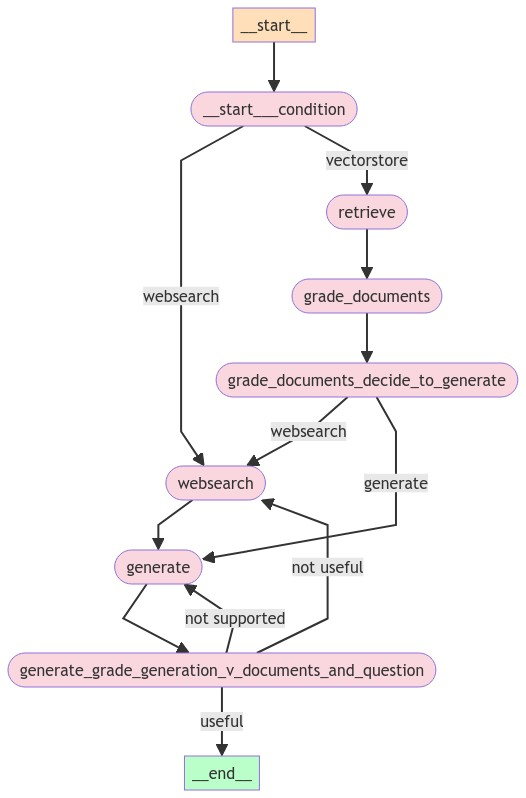

In [89]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod


display(Image(app.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    node_colors=NodeColors(start="#ffdfba", end="#baffc9", other="#fad7de"),
    wrap_label_n_words=9,
    output_file_path=None,
    draw_method=MermaidDrawMethod.API,
    background_color="white",
    padding=20,
)))